# Captioning is Clustering
## Automated Image Classification based on Image Captioning Text for Accessibility
This report proposes a machine learning project that utilizes the Flickr8k dataset, consisting of images and five variations of corresponding captions, to develop a model capable of automatically classifying new images into predefined categories based on generated captions. The first step in this effort will be to identify clusters based on the caption text.  The primary aim is to enhance accessibility by providing automated image categorization. This can be beneficial for visually impaired users, for example. By leveraging techniques in image captioning and natural language processing, this project seeks to create an automated and adaptable system for image classification. This report outlines the existing research in the field, details the planned steps for the project, including exploratory data analysis (EDA), model building, training, and evaluation, and provides a proposed timeline for the project.


## Notebook setup

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import re

import tensorflow as tf
import keras
from keras import layers
from keras.applications import efficientnet
from keras.layers import TextVectorization

import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# set random seed for repeatability
keras.utils.set_random_seed(153)

In [2]:
!pip install keras-visualizer
from keras_visualizer import visualizer

In [3]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 8.5 MB/s eta 0:00:00


In [27]:
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 7.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

## About the Data
Image classification is a fundamental problem in computer vision, with applications ranging from object detection to image retrieval and accessibility enhancements. The Flickr8k dataset provides a rich resource for developing and training models due to its diverse set of images and descriptive captions. By leveraging this dataset, we aim to create an automated system that can categorize images accurately, thereby supporting accessibility initiatives.

Flicker8k includes 2 files. Total size is 1.123 GB. Flickr8k_Dataset.zip is 1.12 GB and Flickr8k_text.zip is 2.34MB

Each image in Flickr8k_Dataset.zip is linked to 5 captions in Flickr8k_text.zip.  An example of a set of captions:

A man in street racer armor is examining the tire of another racers motor bike.

*   A man in street racer armor is examining the tire of another racers motor bike.
* The two racers drove the white bike down the road.
* Two motorists are riding along on their vehicle that is oddly designed and colored.
* Two people are in a small race car driving by a green hill.
* Two people in racing uniforms in a street car.


Paper: Hodosh, Micah, Peter Young, and Julia Hockenmaier. "Framing image description as a ranking task: Data, models and evaluation metrics." Journal of Artificial Intelligence Research 47 (2013): 853-899. https://hockenmaier.cs.illinois.edu/Framing_Image_Description/KCCA.html

Description of dataset by the authors: "We introduce a new benchmark collection for sentence-based image description and search, consisting of 8,000 images that are each paired with five different captions which provide clear descriptions of the salient entities and events. … The images were chosen from six different Flickr groups, and tend not to contain any well-known people or locations, but were manually selected to depict a variety of scenes and situations"

### Download the data and uzip

In [4]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

In [5]:
# location of image files
IMAGES_PATH = "Flicker8k_Dataset"
# image dimensions
IMAGE_SIZE = (299, 299)
# vocab size
VOCAB_SIZE = 10000
# fix the sequence lenght
SEQ_LENGTH = 25

# image embeddings and token embeddings dim
EMBED_DIM = 512
# units in layers of the feed-forward network
FF_DIM = 512
# set some other key parameters
BATCH_SIZE = 64
EPOCHS = 25 #30
# use autotune
AUTOTUNE = tf.data.AUTOTUNE

## Related Literature Review
Recent years have seen considerable progress in the fields of image captioning and image classification. Research has demonstrated that convolutional neural networks (CNNs) and recurrent neural networks (RNNs) can be effectively combined to generate descriptive captions for images (Vinyals et al., 2015). Additionally, transformer models, such as the Vision Transformer (Dosovitskiy et al., 2020), have shown promise in handling image data for various tasks, including caption generation and classification.


Studies have also explored the use of the Flickr8k dataset for training models in image captioning. For instance, Karpathy and Fei-Fei (2015) used deep neural networks to align image regions with natural language phrases, achieving significant results in caption generation. Moreover, recent advances in accessibility research have highlighted the potential benefits of automated image description systems for visually impaired users (Gurari et al., 2020).

## EDA and data pre-preperation
The initial phase of the project involves a thorough exploratory data analysis (EDA) of the Flickr8k dataset. This includes:


1. **Data Inspection:** Understanding the structure and content of the dataset, including image dimensions, caption formats, and any missing values.
2. **Visualization:** Creating visualizations to explore the distribution of image features and caption lengths.
3. **Caption Analysis:** Analyzing the captions to identify common themes, keywords, and patterns that can inform the categorization process.


In [6]:

def load_captions(filename):
    """Loads captions (text) data and maps them to corresponding images.

    Args:
        filename: Path to the text file containing caption data.

    Returns:
        caption_mapping: Dictionary mapping image names and the corresponding captions
        text_data: List containing all the available captions
    """

    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []
        images_to_skip = set()

        for line in caption_data:
            line = line.rstrip("\n")
            # image name and captions separated using a tab in the source file
            img_name, caption = line.split("\t")
            # images repeated five times to match the five different captions.
            img_name = img_name.split("#")[0]
            img_name = os.path.join(IMAGES_PATH, img_name.strip())

            # remove captions too short or too long
            tokens = caption.strip().split()
            if len(tokens) < 5 or len(tokens) > SEQ_LENGTH:
                images_to_skip.add(img_name)
                continue

            # format captions with start and end tags
            if img_name.endswith("jpg") and img_name not in images_to_skip:
                # add a start and an end token to each caption
                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)
                # add to list if first time, else add to end of captions text
                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        #get rid of ones not to include
        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        return caption_mapping, text_data


Preparing the images and captions for model training, including resizing images, tokenizing captions, and creating training and validation splits.

In [7]:
def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # list of all image names
    all_images = list(caption_data.keys())

    # randomize
    if shuffle:
        np.random.shuffle(all_images)

    # train/val split
    train_size = int(len(caption_data) * train_size)
    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    return training_data, validation_data

In [8]:
# get dataset
captions_mapping, text_data = load_captions("Flickr8k.token.txt")

# training and validation sets
train_data, valid_data = train_val_split(captions_mapping)

# check length of each
print("training samples: ", len(train_data))
print("validation samples: ", len(valid_data))

training samples:  6114
validation samples:  1529


Review basic statistics on the datasets

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



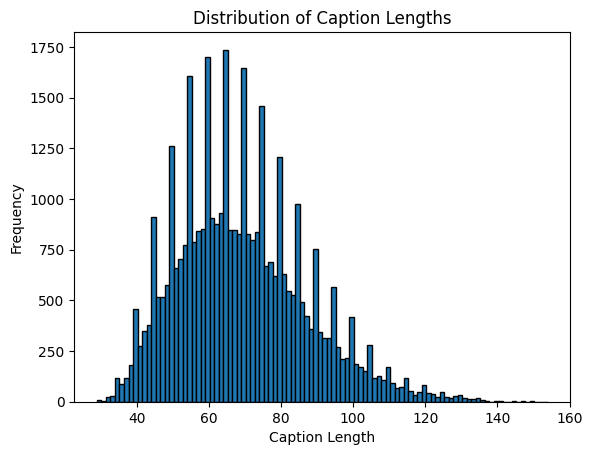

In [9]:
# describe the dataset for captions
print(f"Number of files with caption lenthg in range: {captions_mapping}")
print(f"Number of captions: {len(text_data)}")

# create histogram of caption length by number of characters, show in a chart using matplotlib
# create dataset of caption character lenghts
char_length = [len(caption) for caption in text_data]
# plot in histogram
plt.hist(char_length, bins=100, edgecolor='black')
plt.xlabel('Caption Length')
plt.ylabel('Frequency')
plt.title('Distribution of Caption Lengths')
plt.show()


In [10]:
# vectorize caption data
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

# get rid of unwanted characters
strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

# vectorize
vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)


In [11]:
# augmentation for image data - do some flips and rotate to help generalization on new data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)

Show some examples of augmented images

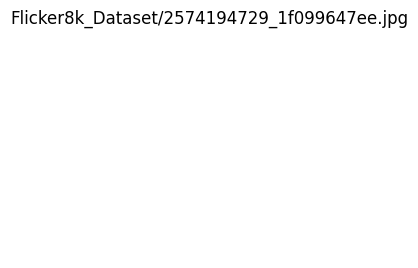

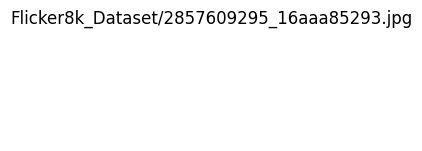

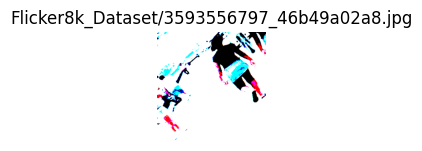

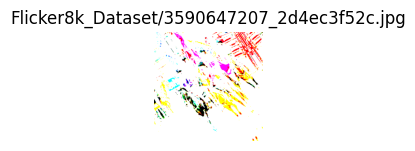

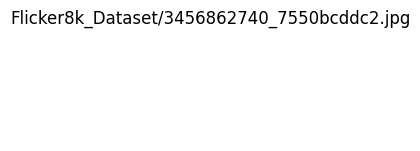

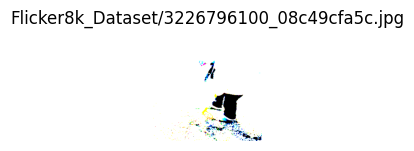

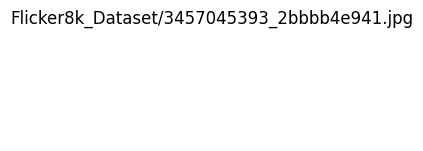

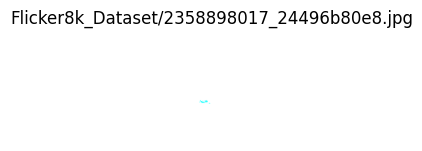

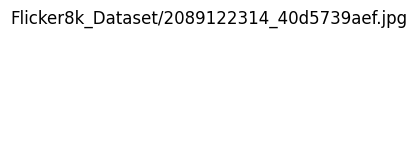

In [17]:
# get a few examples of images to show what rotation and contrast changes do
plt.figure(figsize=(10, 10))
for i in range(9):
    img = tf.io.read_file(list(train_data.keys())[i])
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = image_augmentation(img)
    plt.subplot(3, 3, i + 1)
    # change subplot background to black
    plt.subplot(3, 3, i + 1).set_facecolor('black')
    plt.imshow(img)
    plt.axis("off")

    plt.title(list(train_data.keys())[i])
    plt.show()



## Clustering Text Data
Identify if clusters exist in the captions data using Expectation Maximization methods.

In [18]:
# cluster the vectorized text data using Expectation Maximization methods

from sklearn.mixture import GaussianMixture

# Vectorize the text data
vectorized_text = vectorization(text_data)

# Apply Gaussian Mixture clustering
gmm = GaussianMixture(n_components=5)
gmm.fit(vectorized_text)

# Predict the cluster labels for each caption
cluster_labels = gmm.predict(vectorized_text)

# Print the cluster labels
#print(cluster_labels)
# Print the assigned clusters for the first 10 texts
for i, label in enumerate(cluster_labels[:10]):
    print(f"Text {i+1} is assigned to cluster {label}")

Text 1 is assigned to cluster 4
Text 2 is assigned to cluster 3
Text 3 is assigned to cluster 3
Text 4 is assigned to cluster 3
Text 5 is assigned to cluster 4
Text 6 is assigned to cluster 3
Text 7 is assigned to cluster 3
Text 8 is assigned to cluster 4
Text 9 is assigned to cluster 3
Text 10 is assigned to cluster 3


In [19]:
# use UMAP for dimensionality reduction and plot the caption data with clusters identified by different colors

import matplotlib.pyplot as plt
import umap

# Reduce dimensionality with UMAP
umap_results = umap.UMAP(n_neighbors=15, min_dist=0.0, metric='cosine').fit_transform(vectorized_text)
clustering_results = umap_results

# # Reduce dimensions for plotting
# pca = PCA(n_components=2)
# vt_reduced = pca.fit_transform(vectorized_text)
# clustering_results = vt_reduced

<ipython-input-24-c8b4c3879b42>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', n_clusters)
<ipython-input-24-c8b4c3879b42>:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(clustering_results[indices, 0], clustering_results[indices, 1], c=colors(i), label=f'Cluster {i}')


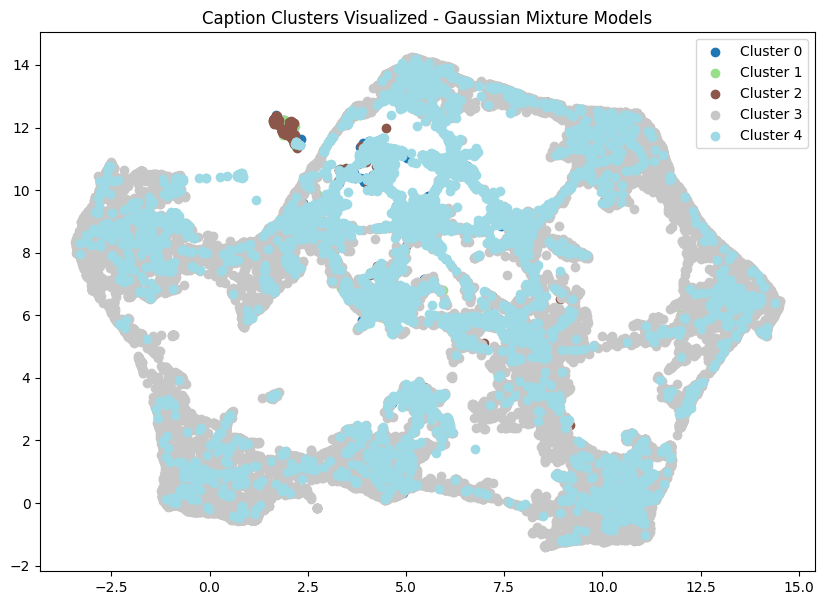

In [24]:
# Plot the results with different colors for each cluster
plt.figure(figsize=(10, 7))

n_clusters = gmm.n_components

colors = plt.cm.get_cmap('tab20', n_clusters)
for i in range(n_clusters):
    indices = np.where(cluster_labels == i)[0]
    plt.scatter(clustering_results[indices, 0], clustering_results[indices, 1], c=colors(i), label=f'Cluster {i}')

# for i in range(n_clusters):
#     cluster_points = vt_reduced[cluster_labels == i]
#     plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}', color=colors(i))

plt.legend()
# add title
plt.title('Caption Clusters Visualized - Gaussian Mixture Models')
plt.show()

## Clustering - K Means
Clustering using K-means methods for comparison

In [22]:
# using the vectorized text, cluster with k-means methods

# Apply K-means clustering
kmeans = KMeans(n_clusters=5)
kmeans.fit(vectorized_text)

# Predict the cluster labels for each caption
cluster_labels_kmeans = kmeans.predict(vectorized_text)
# decode the labels into text representation
#cluster_labels_kmeans = vectorization.get_vocabulary()[cluster_labels_kmeans]

# Print the cluster labels
#print(cluster_labels_kmeans)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<ipython-input-25-1a0b12a6ee3e>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', n_clusters)
<ipython-input-25-1a0b12a6ee3e>:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(clustering_results[indices, 0], clustering_results[indices, 1], c=colors(i), label=f'Cluster {i}')


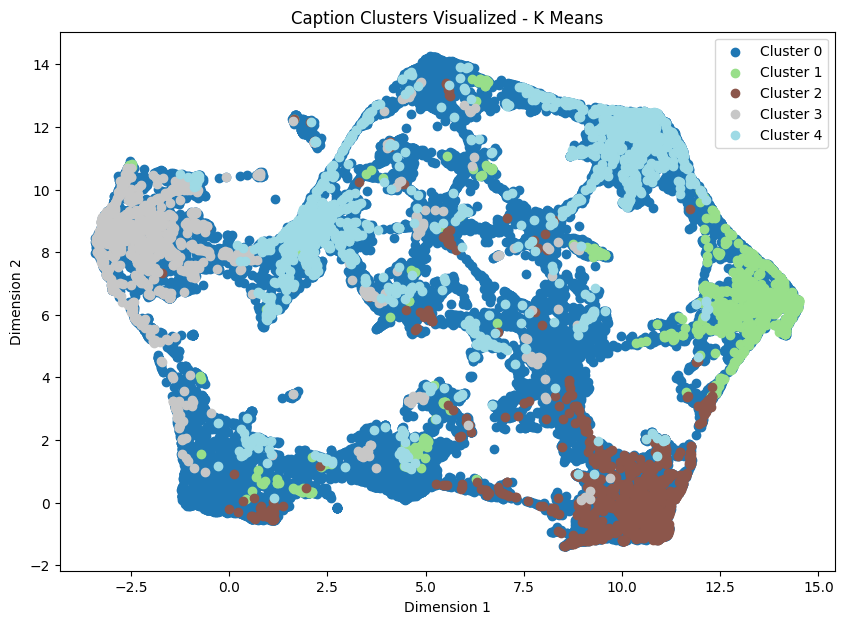

In [25]:
# plot the resulting clusters with color representing each predicted cluster.  Show the label name in a legend.

plt.figure(figsize=(10, 7))

n_clusters = kmeans.n_clusters

colors = plt.cm.get_cmap('tab20', n_clusters)
for i in range(n_clusters):
    indices = np.where(cluster_labels_kmeans == i)[0]
    plt.scatter(clustering_results[indices, 0], clustering_results[indices, 1], c=colors(i), label=f'Cluster {i}')

# add titles, axis labels, and legend
plt.title('Caption Clusters Visualized - K Means')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

In [26]:
# show 5 random examples for each fo the 5 clusters identified in kmeans
for i in range(5):
    print(f"Cluster {i}")
    for j in range(5):
        idx = np.random.choice(np.where(cluster_labels_kmeans == i)[0])
        print(text_data[idx])
    print()



Cluster 0
<start> Lambs on a grassy hill . <end>
<start> Man in a blue coat holding a sign . <end>
<start> A young man holds up a hand written sign next to a woman with a multicolored umbrella . <end>
<start> The three girls sat on the beach . <end>
<start> A girl with a black purse sitting on a wooden bench . <end>

Cluster 1
<start> A large bird swooping down towards the ground . <end>
<start> An orange canoe aimed toward two other canoes on a lake . <end>
<start> A man wearing US flag boxer shorts is standing on a stairway . <end>
<start> a single person squated down at the edge of a pier overlooking a lake <end>
<start> A girl is posed over a statue of a dangerous animal . <end>

Cluster 2
<start> A blue motorcycle and sidecar is being raced on a wet track . <end>
<start> A dog is backlit buy the sun as he jumps up to catch a tennis ball . <end>
<start> A white bird flies agains the backdrop of green foliage . <end>
<start> A pile of dogs sleep on a blue dog bed . <end>
<start> A l

## Embeddings models for clustering
Instead of standard text vectorization, use embeddings then perform clustering

In [29]:
# create an embeddings dataset for both the train and validation datasets
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

# sample list of sentences
sentences = list(train_data.values())

# load a pre-trained model from sentence-transformers
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# create embeddings for each sentence
embeddings = model.encode(sentences)

# number of clusters
num_clusters = 5

# KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(embeddings)
labels = kmeans.labels_

# sentences grouped by cluster
clustered_sentences = {i: [] for i in range(num_clusters)}
for sentence, label in zip(sentences, labels):
    clustered_sentences[label].append(sentence)

# print first 5 example sentences in a cluster
for cluster, sentences in clustered_sentences.items():
    i=0
    print(f"Cluster {cluster}:")
    for sentence in sentences:
        print(f" - {sentence}")
        i+=1
        if i==5:
            break
    print()



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0:
 - ['<start> A woman in a short skirt holds a plastic bottle as she walks down a street with auto and pedestrian traffic . <end>', '<start> A woman is walking down the middle of the road carrying a bottle . <end>', '<start> A woman walking down the side of a highway . <end>', '<start> A woman walking parallel to a yellow line against traffic . <end>', '<start> A woman wearing a jean skirt walks down a city street . <end>']
 - ['<start> A group of women riding horses while holding the flags of multiple nations <end>', '<start> cowgirls waving the United States flag and the Canada flag <end>', '<start> Several people on horseback carrying flags . <end>', '<start> Two women riding horses , carrying the American and Canadian flags at a rodeo . <end>', '<start> Women are riding horses in an arena carrying the flags of Canada and the United States . <end>']
 - ['<start> A laughing woman holding a little girl . <end>', '<start> An older woman and a young child are all smiles in a p

In [53]:
# prepare text processing
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# necessary NLTK data files
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [56]:
def clean_sentence(sentence):
  # extract words from sentences and remove stopwords
    stop_words = set(stopwords.words('english'))
    # get rid of punctuation
    punctuation = set(string.punctuation)
    sentence = sentence.replace("<start> ", "").replace(" <end>", "").strip()
    # get rid of unwanted characters
    sentence = re.sub(r'[^A-Za-z0-9\s]', '', sentence)
    # tokenize the sentence
    words = word_tokenize(sentence)
    filtered_words = [word for word in words if word.lower() not in stop_words and word not in punctuation]
    # reassemble into a sentence form
    filtered_sentence = ' '.join(filtered_words)
    return filtered_sentence

#filtered_sentences = [remove_stopwords(sentence) for sentence in sentences]

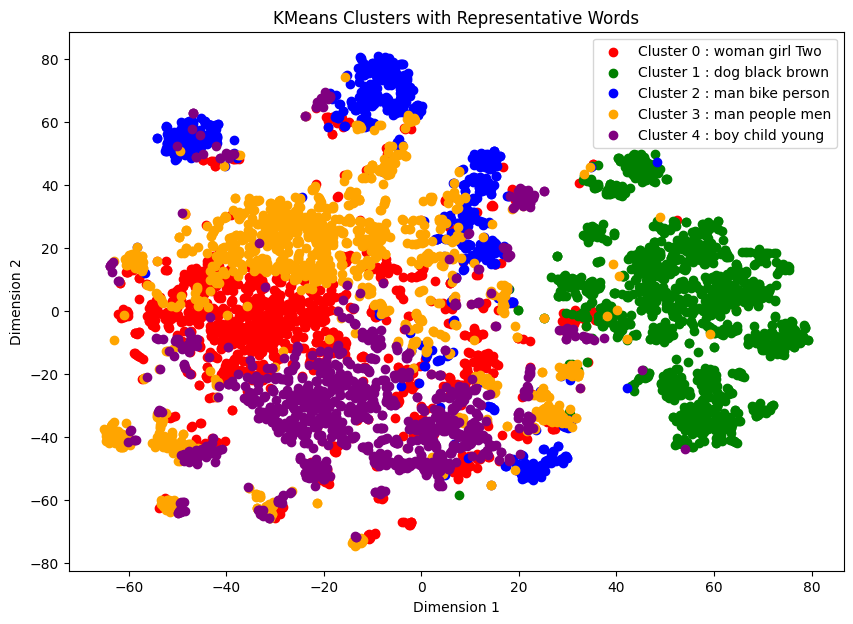

In [58]:
# plot the kmeans clusters on a chart with a cluster label being two words that represent the text data within the clusters.  Show each cluster as a different color

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Get cluster labels
cluster_labels = kmeans.labels_

# Define colors for each cluster
colors = ['red', 'green', 'blue', 'orange', 'purple']

# Reduce dimensionality with tSNE
tsne = TSNE(n_components=2, random_state=42)
clustering_results_embed = tsne.fit_transform(embeddings)


# Find representative words for each cluster
representative_words = {}
for i in range(num_clusters):
    cluster_sentences = clustered_sentences[i]
    words = []
    for sentence_group in cluster_sentences:
        for sentence in sentence_group:
          # remove the <start> and <end> tags from the ground truth caption
          sentence = clean_sentence(sentence)
          # add words to the list
          words.extend(sentence.split())
    # Get most frequent words
    from collections import Counter
    word_counts = Counter(words)
    most_frequent_words = word_counts.most_common(3)
    representative_words[i] = [word for word, count in most_frequent_words]

# remove frequent and uninformative words from the representative_words list


# Create a scatter plot with different colors for each cluster
plt.figure(figsize=(10, 7))
for i in range(num_clusters):
    cluster_points = clustering_results_embed[cluster_labels == i]
    cluster_representative_words = ' '.join(representative_words[i])
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=colors[i], label=f'Cluster {i} : {cluster_representative_words}')

# # Add representative words to the plot
# for i in range(num_clusters):
#     cluster_points = clustering_results_embed[cluster_labels == i]
#     centroid = kmeans.cluster_centers_[i]
#     plt.text(centroid[0], centroid[1], ' '.join(representative_words[i]), color='black')

# Add labels and title
plt.legend()
plt.title('KMeans Clusters with Representative Words')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


### Build pipeline for training
Build pipeline to combine the text caption data and the image data

In [ ]:
# functions to use in model architecture
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)

In [ ]:
# make the train/val datasets with images and captions matching
def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return dataset

# format train/val sets
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))
valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))

## Model Architecture
Build CNN model using Efficient Net.  EfficientNetB0 is a baseline model in the EfficientNet family. It is known for excellent performance and efficiency in terms of parameter size and computational cost. Developed by Google AI, EfficientNet models use a scaling method that uniformly scales all dimensions of depth, width, and resolution using a compound coefficient.

In [ ]:

def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
    )
    # freeze the feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model


### Transformer encoding block
A transformer enoding block is primarily responsible for processing and encoding input data (in this case, image features) into a set of representations that capture the contextual information necessary for the subsequent caption generation by the decoder. In this image captioning model, the encoder's role is to transform the raw image data into meaningful feature vectors that the decoder can then use to generate descriptive captions.

In [ ]:
class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1

### Positional Embedding Block
The Positional Embeddings Block in an image captioning model injects crucial positional information into the input embeddings, allowing the Transformer model to understand and utilize the order of tokens or features. This enhances the model's ability to generate coherent and contextually accurate captions for images.

Transformers do not inherently understand the order of input sequences because they process input data in parallel. Positional embeddings provide a way to encode the order of the input tokens (words or features) so that the model can utilize this positional information effectively.

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

### Transformer Decoder Block
In an image captioning model, the Transformer Decoder is responsible for generating textual descriptions (captions) of images by sequentially predicting the next word in the caption given the image features and the previous words.

In [ ]:
class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM,
            sequence_length=SEQ_LENGTH,
            vocab_size=VOCAB_SIZE,
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [
                tf.expand_dims(batch_size, -1),
                tf.constant([1, 1], dtype=tf.int32),
            ],
            axis=0,
        )
        return tf.tile(mask, mult)


### Combine together to create the image captioning model
Assemble the cnn, encoder, and decoder blocks together

In [ ]:
class ImageCaptioningModel(keras.Model):
    def __init__(
        self,
        cnn_model,
        encoder,
        decoder,
        num_captions_per_image=5,
        image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # get image embeddings
        img_embed = self.cnn_model(batch_img)

        # pass each of the five captions one by one to the decoder along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # gradients
            grads = tape.gradient(loss, train_vars)

            # update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # return loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # get image embeddings
        img_embed = self.cnn_model(batch_img)

        # pass each of the five captions one by one to the decoder along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    @property
    def metrics(self):
        # list metrics so `reset_states()` called automatically.
        return [self.loss_tracker, self.acc_tracker]

In [ ]:
# create CNN model for image feature extraction
cnn_model = get_cnn_model()
# create encoder portion of the model
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
# create decoder portion of the model
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)

# put all together to build the full captioning model
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model,
    encoder=encoder,
    decoder=decoder,
    image_aug=image_augmentation,
)

16705208/16705208 [==============================] - 2s 0us/step


Visualize the full model architecture

In [ ]:
# use keras model visualizer to generate an image of the model architecture for the caption_model

#visualizer(caption_model, file_format='png', view=True)
visualizer(cnn_model, file_format='png', view=True)
#visualizer(encoder, file_format='png', view=True)
#visualizer(decoder, file_format='png', view=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.344923 to fit


View architecture of CNN model in summary form.

In [ ]:
cnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 299, 299, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 299, 299, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 299, 299, 3)          0         ['normalization[0][0]']   

## Model Training
Run iterations on the training data.  Include a Learing Rate Scheduler (LRS) for some hyperparameter tuning.  A Learning Rate Scheduler (LRS) is a tool used to adjust the learning rate of the optimizer during training dynamically. The learning rate is a critical hyperparameter in training neural networks. It determines the step size at each iteration while moving toward a minimum of the loss function. An effective LRS helps improve training efficiency, convergence speed, and model performance.

In [ ]:
# loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    reduction='none',
)

# early stopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)


# Learning Rate Scheduler (LRS) for optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


# create LRS
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# compile
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# fit
history = caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

Epoch 1/25
96/96 [==============================] - 73s 531ms/step - loss: 27.5950 - acc: 0.1388 - val_loss: 20.2822 - val_acc: 0.3180
Epoch 2/25
96/96 [==============================] - 43s 452ms/step - loss: 19.2328 - acc: 0.3206 - val_loss: 17.9125 - val_acc: 0.3607
Epoch 3/25
96/96 [==============================] - 43s 448ms/step - loss: 17.3346 - acc: 0.3556 - val_loss: 16.8420 - val_acc: 0.3770
Epoch 4/25
96/96 [==============================] - 43s 447ms/step - loss: 16.2289 - acc: 0.3743 - val_loss: 16.1886 - val_acc: 0.3915
Epoch 5/25
96/96 [==============================] - 43s 447ms/step - loss: 15.4465 - acc: 0.3898 - val_loss: 15.7826 - val_acc: 0.3982
Epoch 6/25
96/96 [==============================] - 43s 449ms/step - loss: 14.8018 - acc: 0.4017 - val_loss: 15.4655 - val_acc: 0.4047
Epoch 7/25
96/96 [==============================] - 43s 445ms/step - loss: 14.2665 - acc: 0.4133 - val_loss: 15.2667 - val_acc: 0.4093
Epoch 8/25
96/96 [==============================] - 43s

Chart the training and validation loss curves

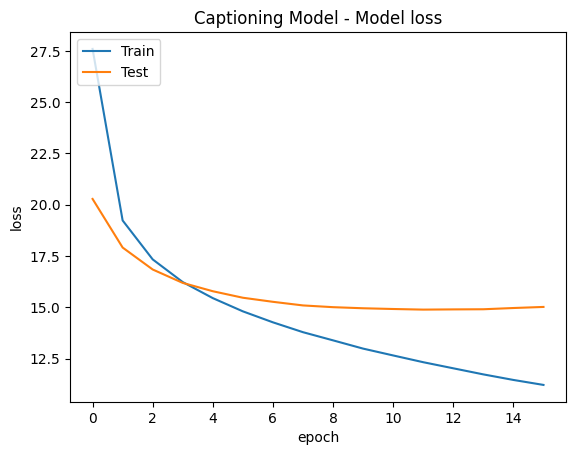

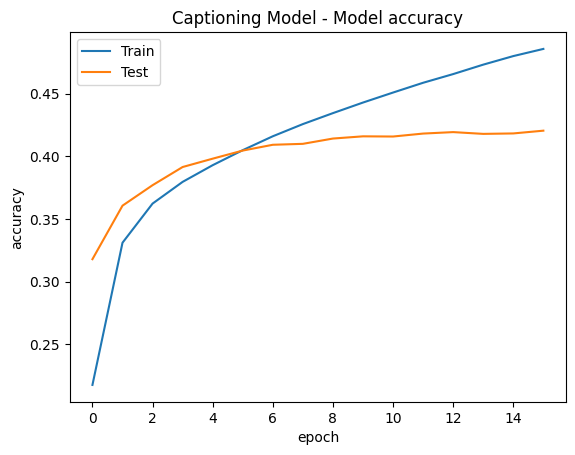

In [ ]:
# use matplotlib to graph the training and validation loss from the history of model training

import matplotlib.pyplot as plt

# Get the number of epochs
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Captioning Model - Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

print("\n")

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Captioning Model - Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Model Training Discussion
Reviewing the training versus validation loss shows an elbow around 6-8 epochs.  The validation loss only has minimal improvement.  Model accuracy improves only slightly after about 8 epochs.  This indicates the model in current state will have about 42% accuracy.

## Testing
Test some samples

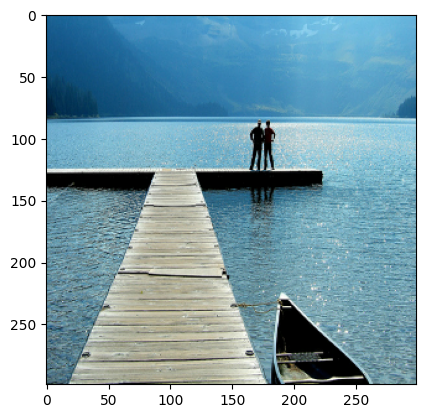

Predicted Caption:  a man is sitting on a dock overlooking a city




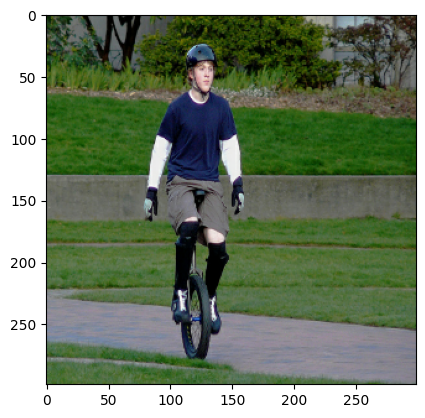

Predicted Caption:  a man in a white shirt is riding a bicycle on a baseball field




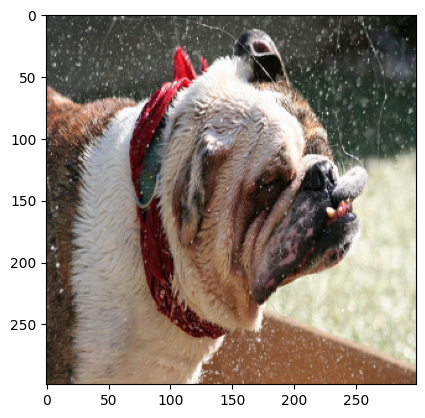

Predicted Caption:  a dog is playing with a red and white dog


In [ ]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())


def generate_caption():
    # select random image from validation set
    sample_img = np.random.choice(valid_images)
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    # show the image
    plt.imshow(img)
    plt.show()

    # pass to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # pass image features to encoder
    encoded_img = caption_model.encoder(img, training=False)

    # generate caption using decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print("Predicted Caption: ", decoded_caption)


# check a few predictions
generate_caption()
print("\n")
generate_caption()
print("\n")
generate_caption()

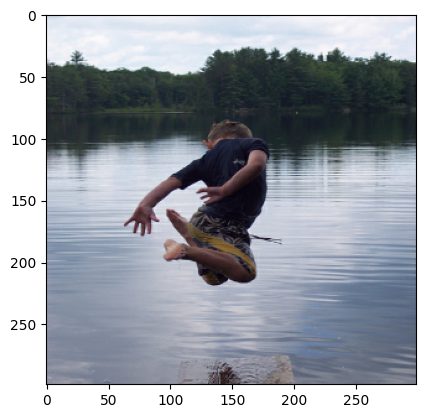

Predicted Caption:  a man is jumping into the water


In [ ]:
generate_caption()

## Evaluation
Check on accuracy of generated captions versus some random samples from validation dataset.  Use BLEU score methods.

The BLEU (Bilingual Evaluation Understudy) score is a metric used to evaluate the quality of text generated by machine translation and other natural language processing (NLP) systems. It measures how closely the generated text matches a set of reference texts (usually human translations).

 BLEU scores range from 0 to 1. A score of 1 means a perfect match between the candidate and reference texts, while a score of 0 means no overlap.  BLEU works better with multiple reference examples, providing a more comprehensive assessment of the candidate caption.  BLEU measures surface-level similarity and may not account for semantic equivalence between between reference (validation examples) and predicted test.

In [ ]:
def generate_caption_text_only(image_key):
    # select image from validation set
    sample_img = decode_and_resize(image_key)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)

    # pass to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # pass image features to encoder
    encoded_img = caption_model.encoder(img, training=False)

    # generate caption using decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()

    return decoded_caption

In [ ]:
# set number of test samples
import random

num_samples = 100

predictions =[]

for sample in range(num_samples):
  # get random image from validation data
  random_image = random.choice(list(valid_data.keys()))
  # get corresponding caption to keep for testing
  true_caption = valid_data[random_image]

  # generate caption using the model
  predicted_caption = generate_caption_text_only(random_image)

  # print true and predicted captions (diagnostics)
  #print("True Caption:", true_caption)
  #print("Predicted Caption:", predicted_caption)

  # add the image name, predicted caption, and true caption to predictions list
  predictions.append((random_image, predicted_caption, true_caption))




In [ ]:
# use the predictions list to calculate BLEU score
# validate against the ground truth caption sets using BLEU score method
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# calculate the BLEU score for each image
img_bleu_scores = []
smoothing_function = SmoothingFunction().method1

for pred_set in predictions:
    # get the ground truth caption
    ground_truth_caption_raw = pred_set[2]
    ground_truth_caption = []
    for sentence in ground_truth_caption_raw:
      # remove the <start> and <end> tags from the ground truth caption
      clean_caption = sentence.replace("<start> ", "").replace(" <end>", "").strip().split()
      #print(clean_caption)
      # append to the ground truth caption list
      ground_truth_caption += clean_caption

    # get the predicted caption
    predicted_caption = pred_set[1]

    # calculate the BLEU score
    bleu_score = sentence_bleu([ground_truth_caption], predicted_caption.split(), smoothing_function=smoothing_function)
    img_bleu_scores.append(bleu_score)

# print the average BLEU score
print("Average BLEU score:", sum(img_bleu_scores) / len(img_bleu_scores))


Average BLEU score: 0.004018955958480653


## Conclusions
As can be seen from the BLEU scores calculations, results are fairly poor with a score of only 0.004 on 100 samples. Future improvements can be made by more hyperparameter tuning, model architecture tweaking and improved embedding methodology with latest LLM embedding methods.

Accuracy measures were around 42%.  Some hyperparameter tuning was implemented with Learning Rate Scheduler (LRS) for optimization. However, more tuning could be done with grid search for turning.  Using variations on the CNN architecture to test impact along with varying settings, such as the dropout rate, may also yield some improvements.

Further testing with larger sample size would help with diagnostics.

### Attributions

Image captioning architecture reference: https://keras.io/examples/vision/image_captioning/

Clustering/UMAP: https://programminghistorian.org/en/lessons/clustering-visualizing-word-embeddings

BLEU scores: https://en.wikipedia.org/wiki/BLEU